In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as tf_dataloader
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import OrderedDict
import torch.optim as optim

In [2]:
def store(model):
    """
    make hook for feature map
    """
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.pool_locs[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=3, stride=3, return_indices=True),
            
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=3, stride=3, return_indices=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )
        
        self.conv_layers_indices = [0, 2]
        
        self.feature_maps = OrderedDict()
        
        self.pool_locs = OrderedDict()

    def forward(self, x):
        for idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
                self.pool_locs[idx] = location
            else:
                x = layer(x)
                
        x = x.view(x.size()[0], -1)
        output = self.classifier(x)
        return output

In [4]:
class NetDeconv(nn.Module):
    def __init__(self, net):
        super().__init__()
        
        self.features = nn.Sequential(
            # Deconv 1
            nn.MaxUnpool2d(kernel_size=3, stride=3),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3),
            
            # Deconv 2
            nn.MaxUnpool2d(kernel_size=3, stride=3),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3),
        )
        
        self.conv2deconv_indices = {
            0: 1,
            2: 3,
        }
        
        self.unpool2pool_indices = {
            0: 1,
            2: 3,
        }
        
        
        # Inicializa los pesos de la red deconvolucional con los pesos de la red convolucional
        conv_layers = [layer for idx, layer in enumerate(net.features) if isinstance(layer, nn.Conv2d) and idx in self.conv2deconv_indices.keys()]
        deconv_layers = [layer for idx, layer in enumerate(self.features) if isinstance(layer, nn.ConvTranspose2d) and idx in self.conv2deconv_indices.values()]
        assert len(conv_layers) == len(deconv_layers), "Number of convolutional and deconvolutional layers must match"
        for conv_layer, deconv_layer in zip(conv_layers, deconv_layers):
            deconv_layer.weight.data = conv_layer.weight.data
            deconv_layer.bias.data = torch.tensor([conv_layer.bias.data.mean()])
                
        
    def forward(self, x, layer, activation_idx, pool_locs):
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        else:
            raise ValueError('layer is not a conv feature map')

        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                x = self.features[idx]\
                (x, pool_locs[self.unpool2pool_indices[idx]])
            else:
                x = self.features[idx](x)
                
        return x
        

In [5]:
def vis_layer(layer, net, net_deconv):
    """
    visualing the layer deconv result
    """
    num_feat = net.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = net.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != net.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    print(max_activation)
    
    deconv_output = net_deconv(new_feat_map, layer, mark, net.pool_locs)
    #deconv_output = net_deconv(new_feat_map, net.conv_indices, net.pool_indices)

    new_img = deconv_output.data.cpu().numpy()[0].transpose(1, 2, 0) # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

batch_size = 1

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = tf_dataloader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = tf_dataloader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))  # MNIST classes are digits from 0 to 9


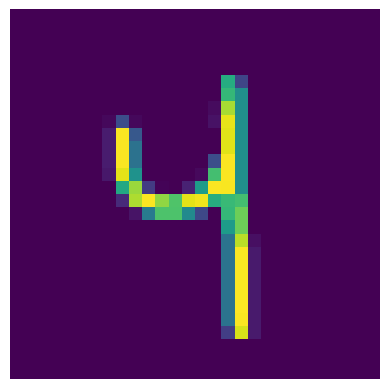

In [7]:
# functions to show an image
def imshow(img):
    img = img.cpu().numpy()[0].transpose(1, 2, 0)
    img = (img * 0.5) + 0.5
    plt.imshow(img)
    plt.axis('off') 
    plt.savefig('image.jpg', transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()
    return img

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_path = 'image.jpg'
# show images
img = imshow(images)

In [8]:
net = Net()
net.load_state_dict(torch.load('net_deconv.pth'))
net.eval()
store(net)
conv_output = net(images.clone().detach())
pool_locs = net.pool_locs
print('Predicted:', classes[torch.argmax(conv_output)], 'Actual:', labels[0])

Predicted: 4 Actual: tensor(4)


tensor(2.1933, grad_fn=<MaxBackward1>)


RuntimeError: Expected shape of indices to be same as that of the input tensor ([1, 1, 28, 28]) but got indices tensor with shape: [1, 64, 2, 2]

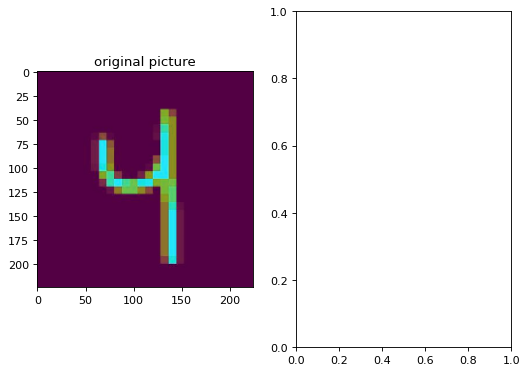

In [9]:
# backward processing
net_deconv = NetDeconv(net)
net_deconv.eval()
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.subplot(2, 4, 1)
plt.title('original picture')
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
plt.imshow(img)    
#for idx, layer in enumerate([14, 17, 19, 21, 24, 26, 28]):
for idx, layer in enumerate(net.conv_layers_indices):        
    plt.subplot(2, 4, idx+2)
    img, activation = vis_layer(layer, net, net_deconv)
    plt.title(f'{layer} layer, the max activations is {activation}')
    # img = img[112:,112:,:]
    plt.imshow(img)
    # plt.colorbar()